# Imports

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Environment

In [45]:
rows, cols = 6, 7
gamma = 0.9  
alpha = 0.001

# grid with walls (1), agent (2), box (3), storage (4), and empty spaces (5)
grid = np.array([
    [1, 1, 1, 1, 5, 5],
    [1, 0, 2, 1, 5, 5],
    [1, 0, 0, 1, 1, 1],
    [1, 4, 0, 0, 0, 1],
    [1, 0, 0, 3, 0, 1],
    [1, 0, 0, 1, 1, 1],
    [1, 1, 1, 1, 5, 5]
])
actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
action_effects = {
    'UP': (-1, 0),
    'DOWN': (1, 0),
    'LEFT': (0, -1),
    'RIGHT': (0, 1)
}

reward_grid = np.full((rows, cols), -1)
reward_grid[3, 1] = 0  

# Check valid positions
def is_valid(pos):
    r, c = pos
    return 0 <= r < rows and 0 <= c < cols and grid[r, c] not in (1, 5)

# Apply action to a position
def move_agent(agent_pos, action):
    new_pos = (agent_pos[0] + action_effects[action][0], agent_pos[1] + action_effects[action][1])
    if is_valid(new_pos):
        return new_pos
    return agent_pos  # Agent stays in the same position (Invalid Move)


# Value Iteration

In [46]:
V = np.zeros((rows, cols))

def value_iteration():
    global V
    while True:
        delta = 0
        for r in range(1, rows - 1):
            for c in range(1, cols - 1):
                if grid[r, c] in (1, 5): 
                    continue
                
                old_value = V[r, c]
                new_value = float('-inf')
                
                for action in actions:
                    agent_pos = (r, c)
                    new_agent_pos = move_agent(agent_pos, action)
                    
                    # Update value using the Bellman equation
                    reward = reward_grid[new_agent_pos]
                    new_value = max(new_value, reward + gamma * V[new_agent_pos])
                
                # Update value for current state
                V[r, c] = new_value
                delta = max(delta, abs(old_value - new_value))
        
        # Stop if the value function has converged
        if delta < alpha:
            break
        
value_iteration()

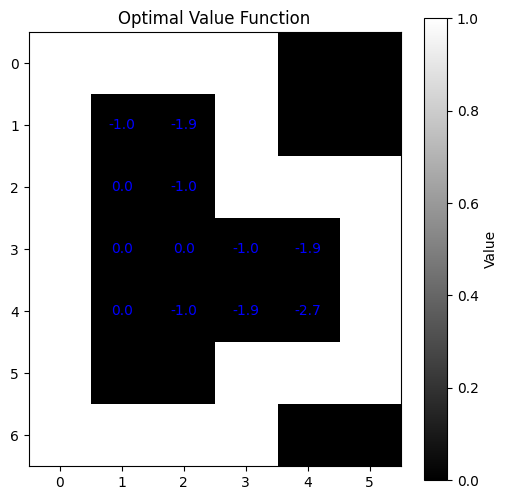

In [44]:
def plot_value_function(V):
    plt.figure(figsize=(6, 6))
    plt.imshow(grid == 1, cmap='gray')  
    
    for r in range(1, rows - 1):
        for c in range(1, cols - 1):
            if grid[r, c] not in (1, 5): 
                plt.text(c, r, f'{V[r, c]:.1f}', ha='center', va='center', color='blue')
    
    plt.title("Optimal Value Function")
    plt.gca()  
    plt.colorbar(label="Value")
    plt.show()

plot_value_function(V)

#  Monte Carlo with exploring starts

In [41]:
num_episodes = 1000

# Initialize value function and returns
V_first_visit = np.zeros((rows, cols))
V_every_visit = np.zeros((rows, cols))
returns_first_visit = np.zeros((rows, cols))
returns_every_visit = np.zeros((rows, cols))
visit_counts_first_visit = np.zeros((rows, cols))
visit_counts_every_visit = np.zeros((rows, cols))


def monte_carlo():
    for _ in range(num_episodes):
        while True:
            start_pos = (np.random.randint(1, rows - 1), np.random.randint(1, cols - 1))
            if grid[start_pos] == 0:  
                break
        
        # Generate episode
        episode = []
        total_reward = 0
        state = start_pos
        
        while True:
            action = np.random.choice(actions) 
            next_state = move_agent(state, action)
            reward = reward_grid[next_state]
            episode.append((state, action, reward))
            state = next_state
            total_reward += reward
            
            if reward == 0: 
                break

        # First-Visit Update
        visited_states = set()
        for t, (s, a, r) in enumerate(episode):
            if s not in visited_states:
                visited_states.add(s)
                G = sum([episode[k][2] for k in range(t, len(episode))])  
                returns_first_visit[s] += G
                visit_counts_first_visit[s] += 1
                V_first_visit[s] = returns_first_visit[s] / visit_counts_first_visit[s]
        
        # Every-Visit Update
        for s, a, r in episode:
            G = sum([r for _, _, r in episode]) 
            returns_every_visit[s] += G
            visit_counts_every_visit[s] += 1
            V_every_visit[s] = returns_every_visit[s] / visit_counts_every_visit[s]

monte_carlo()

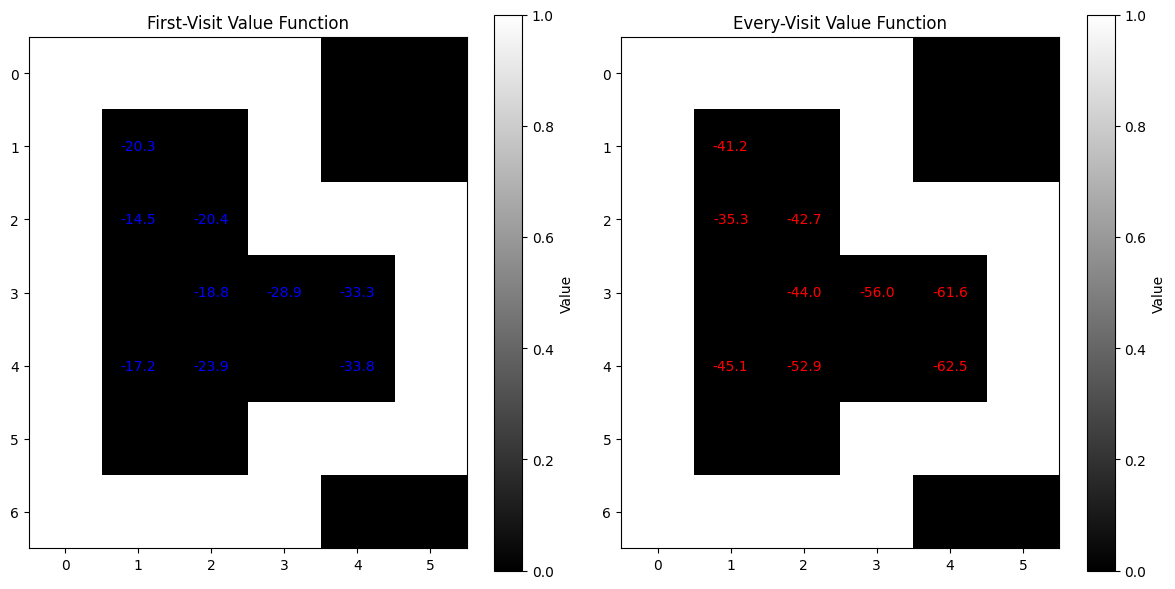

In [40]:
def plot_value_functions(V_first, V_every):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(grid == 1, cmap='gray') 
    for r in range(1, rows - 1):
        for c in range(1, cols - 1):
            if grid[r, c] == 0: 
                plt.text(c, r, f'{V_first[r, c]:.1f}', ha='center', va='center', color='blue')
    plt.title("First-Visit Value Function")
    plt.colorbar(label="Value")

    plt.subplot(1, 2, 2)
    plt.imshow(grid == 1, cmap='gray')
    for r in range(1, rows - 1):
        for c in range(1, cols - 1):
            if grid[r, c] == 0: 
                plt.text(c, r, f'{V_every[r, c]:.1f}', ha='center', va='center', color='red')
    plt.title("Every-Visit Value Function")
    plt.colorbar(label="Value")

    plt.tight_layout()
    plt.show()

plot_value_functions(V_first_visit, V_every_visit)